<a href="https://colab.research.google.com/github/ksnugroho/teori-praktik-cv-part1/blob/main/Bagian_2_Bab_6_6_8_Visualisasi_Hasil_Pembelajaran_Fitur.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import numpy as np
import torch
import torch.nn as nn
import matplotlib.pyplot as plt
import seaborn as sns

from torch.optim import Adam
from torch.utils.data import Dataset, DataLoader
from torchvision import datasets

device = 'cuda' if torch.cuda.is_available() else 'cpu'

# Mengunduh Dataset

In [ ]:
data_folder = './data/FMNIST'

train_data = datasets.FashionMNIST(data_folder, download=True, train=True)
val_data = datasets.FashionMNIST(data_folder, download=True, train=False)

tr_images, tr_targets = train_data.data, train_data.targets
val_images, val_targets = val_data.data, val_data.targets

100%|██████████| 26.4M/26.4M [00:01<00:00, 13.4MB/s]


Extracting ./data/FMNIST/FashionMNIST/raw/train-images-idx3-ubyte.gz to ./data/FMNIST/FashionMNIST/raw



100%|██████████| 29.5k/29.5k [00:00<00:00, 198kB/s]


Extracting ./data/FMNIST/FashionMNIST/raw/train-labels-idx1-ubyte.gz to ./data/FMNIST/FashionMNIST/raw



100%|██████████| 4.42M/4.42M [00:01<00:00, 3.69MB/s]


Extracting ./data/FMNIST/FashionMNIST/raw/t10k-images-idx3-ubyte.gz to ./data/FMNIST/FashionMNIST/raw



100%|██████████| 5.15k/5.15k [00:00<00:00, 21.5MB/s]

Extracting ./data/FMNIST/FashionMNIST/raw/t10k-labels-idx1-ubyte.gz to ./data/FMNIST/FashionMNIST/raw



In [ ]:
class FMNISTDataset(Dataset):
    def __init__(self, x, y, aug=None):
        self.x = x
        self.y = y
        self.aug = aug
    def __getitem__(self, ix):
        x, y = self.x[ix], self.y[ix]
        return x.numpy(), y.item()
    def __len__(self):
        return len(self.x)
    def collate_fn(self, batch):
        ims, classes = list(zip(*batch))
        if self.aug:
            ims = self.aug.augment_images(ims)
        ims = np.array(ims)
        ims = torch.tensor(ims)[:,None,:,:].to(device)/255.
        classes = torch.tensor(classes).to(device)
        return ims, classes

# Augmentasi Gambar

In [ ]:
from imgaug import augmenters as iaa

aug = iaa.Sequential([
    iaa.Affine(translate_px={"x": (-10, 10)}, mode="constant")
])

# Melatih Model

In [ ]:
def get_data():
    train = FMNISTDataset(tr_images, tr_targets, aug=aug)
    trn_dl = DataLoader(train, batch_size=32, collate_fn=train.collate_fn, shuffle=True)
    val = FMNISTDataset(val_images, val_targets)
    val_dl = DataLoader(val, batch_size=len(val_images), collate_fn=val.collate_fn, shuffle=False)
    return trn_dl, val_dl

# Definisi model Convolutional Neural Network
def get_model():
    model = nn.Sequential(
        nn.Conv2d(1, 64, kernel_size=3),
        nn.MaxPool2d(2),
        nn.ReLU(),
        nn.Conv2d(64, 128, kernel_size=3),
        nn.MaxPool2d(2),
        nn.ReLU(),
        nn.Flatten(),
        nn.Linear(3200, 256),
        nn.ReLU(),
        nn.Linear(256, 10)
    ).to(device)

    loss_fn = nn.CrossEntropyLoss()
    optimizer = Adam(model.parameters(), lr=0.001)

    return model, loss_fn, optimizer

def train_batch(x, y, model, opt, loss_fn):
    prediction = model(x)
    batch_loss = loss_fn(prediction, y)
    batch_loss.backward()
    optimizer.step()
    optimizer.zero_grad()
    return batch_loss.item()

def accuracy(x, y, model):
    model.eval()
    with torch.no_grad():
        prediction = model(x)
    max_values, argmaxes = prediction.max(-1)
    is_correct = argmaxes == y
    return is_correct.cpu().numpy().tolist()

def val_loss(x, y, model):
    with torch.no_grad():
        prediction = model(x)
        val_loss = loss_fn(prediction, y)
    return val_loss.item()

In [ ]:
trn_dl, val_dl = get_data()
model, loss_fn, optimizer = get_model()

train_losses, train_accuracies = [], []
val_losses, val_accuracies = [], []

for epoch in range(5):
    print(f"Epoch {epoch + 1}")
    train_epoch_losses, train_epoch_accuracies = [], []

    for x, y in trn_dl:
        batch_loss = train_batch(x, y, model, optimizer, loss_fn)
        train_epoch_losses.append(batch_loss)
    train_epoch_loss = np.array(train_epoch_losses).mean()

    for x, y in trn_dl:
        is_correct = accuracy(x, y, model)
        train_epoch_accuracies.extend(is_correct)
    train_epoch_accuracy = np.mean(train_epoch_accuracies)

    for x, y in val_dl:
        val_is_correct = accuracy(x, y, model)
        validation_loss = val_loss(x, y, model)
    val_epoch_accuracy = np.mean(val_is_correct)

    train_losses.append(train_epoch_loss)
    train_accuracies.append(train_epoch_accuracy)
    val_losses.append(validation_loss)
    val_accuracies.append(val_epoch_accuracy)

    print(f"Train Loss: {train_epoch_loss:.4f}, Train Accuracy: {train_epoch_accuracy:.4f}")
    print(f"Validation Loss: {validation_loss:.4f}, Validation Accuracy: {val_epoch_accuracy:.4f}")

Epoch 1
Train Loss: 0.6665, Train Accuracy: 0.7933
Validation Loss: 0.5285, Validation Accuracy: 0.7988
Epoch 2
Train Loss: 0.4207, Train Accuracy: 0.8641
Validation Loss: 0.3663, Validation Accuracy: 0.8692
Epoch 3
Train Loss: 0.3601, Train Accuracy: 0.8461
Validation Loss: 0.4310, Validation Accuracy: 0.8435
Epoch 4
Train Loss: 0.3278, Train Accuracy: 0.8881
Validation Loss: 0.3386, Validation Accuracy: 0.8806
Epoch 5
Train Loss: 0.3059, Train Accuracy: 0.8889
Validation Loss: 0.3085, Validation Accuracy: 0.8870


<ipython-input-7-a750592e9e98>:21: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  plt.gca().set_yticklabels(['{:.0f}%'.format(x * 100) for x in plt.gca().get_yticks()])


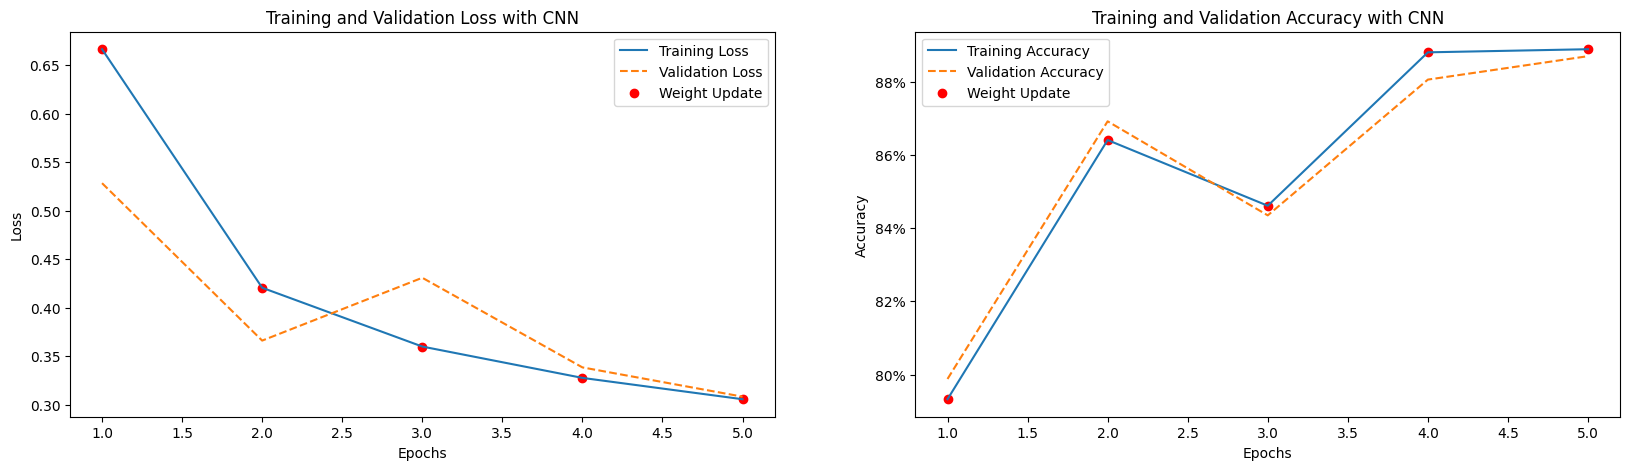

In [ ]:
epochs = np.arange(5) + 1

plt.figure(figsize=(20, 5))

plt.subplot(1, 2, 1)
plt.plot(epochs, train_losses, label='Training Loss')
plt.plot(epochs, val_losses, label='Validation Loss', linestyle='--')
plt.scatter(epochs, train_losses, color='red', label='Weight Update')
plt.title('Training and Validation Loss with CNN')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(epochs, train_accuracies, label='Training Accuracy')
plt.plot(epochs, val_accuracies, label='Validation Accuracy', linestyle='--')
plt.scatter(epochs, train_accuracies, color='red', label='Weight Update')
plt.title('Training and Validation Accuracy with CNN')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.gca().set_yticklabels(['{:.0f}%'.format(x * 100) for x in plt.gca().get_yticks()])
plt.legend()

plt.show()

# Visualisasi Pembelajaran Fitur

## Filter pada Lapisan Konvolusi Pertama

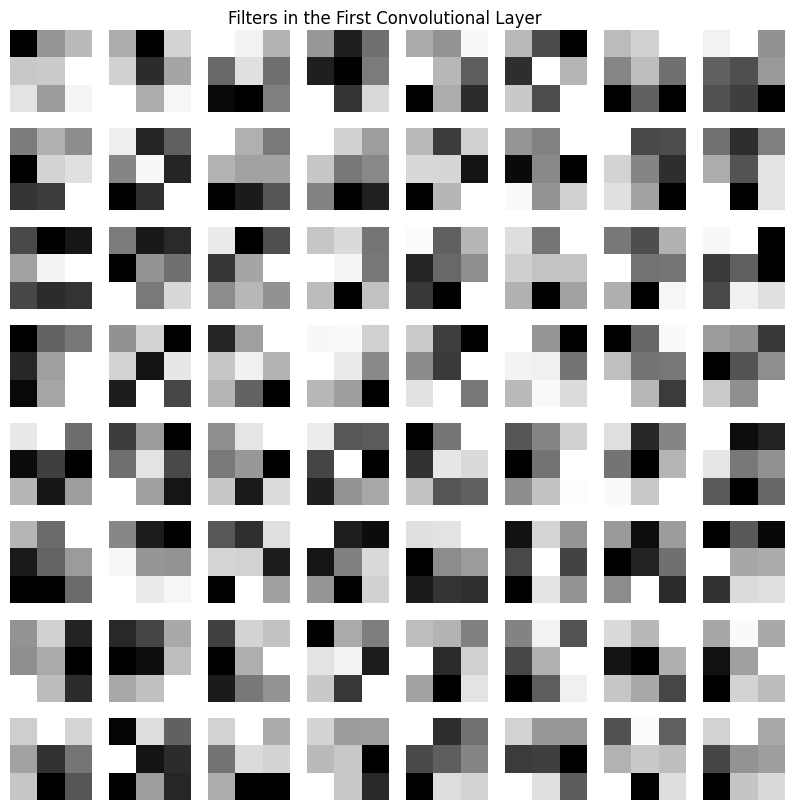

In [ ]:
first_layer_weights = model[0].weight.data.cpu().numpy()

fig, axes = plt.subplots(8, 8, figsize=(10, 10))
for i, ax in enumerate(axes.flat):
    if i < first_layer_weights.shape[0]:
        ax.imshow(first_layer_weights[i, 0], cmap='gray')
        ax.axis('off')
plt.suptitle('Filters in the First Convolutional Layer', y=0.9)
plt.show()

## Aktivasi Filter pada Lapisan Konvolusi Pertama

In [ ]:
# Mengambil batch gambar
x_batch, _ = next(iter(trn_dl))
x_batch = x_batch.to(device)

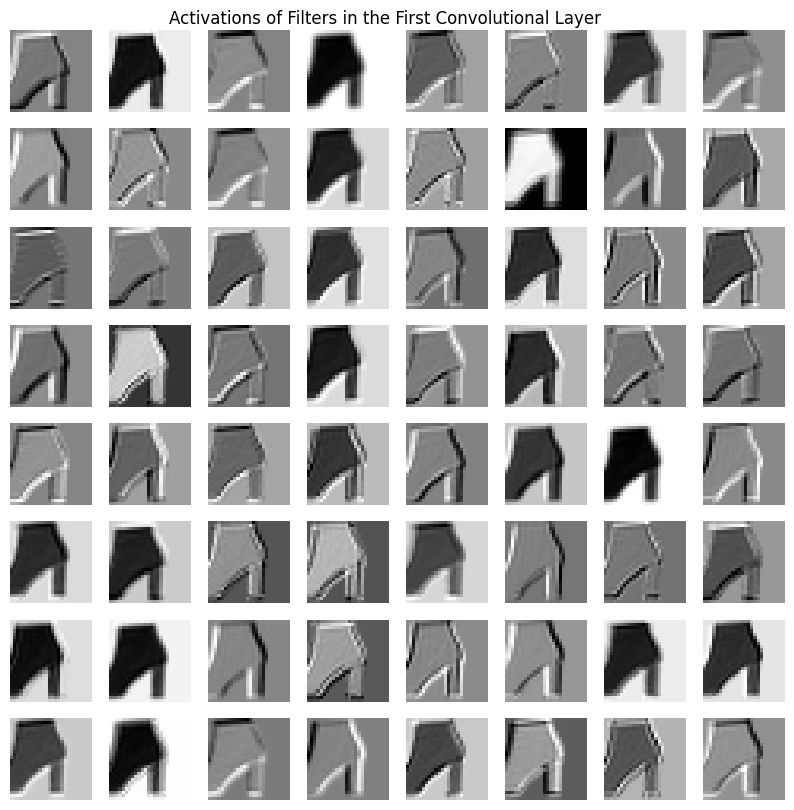

In [ ]:
# Aktivasi lapisan pertama
first_layer_activations = model[0](x_batch).detach().cpu()

# Visualisasi aktivasi
fig, axes = plt.subplots(8, 8, figsize=(10, 10))
for i, ax in enumerate(axes.flat):
    if i < first_layer_activations.shape[1]:
        ax.imshow(first_layer_activations[0, i], cmap='gray')
        ax.axis('off')
plt.suptitle('Activations of Filters in the First Convolutional Layer', y=0.9)
plt.show()

## Aktivasi Filter pada Lapisan Konvolusi Kedua

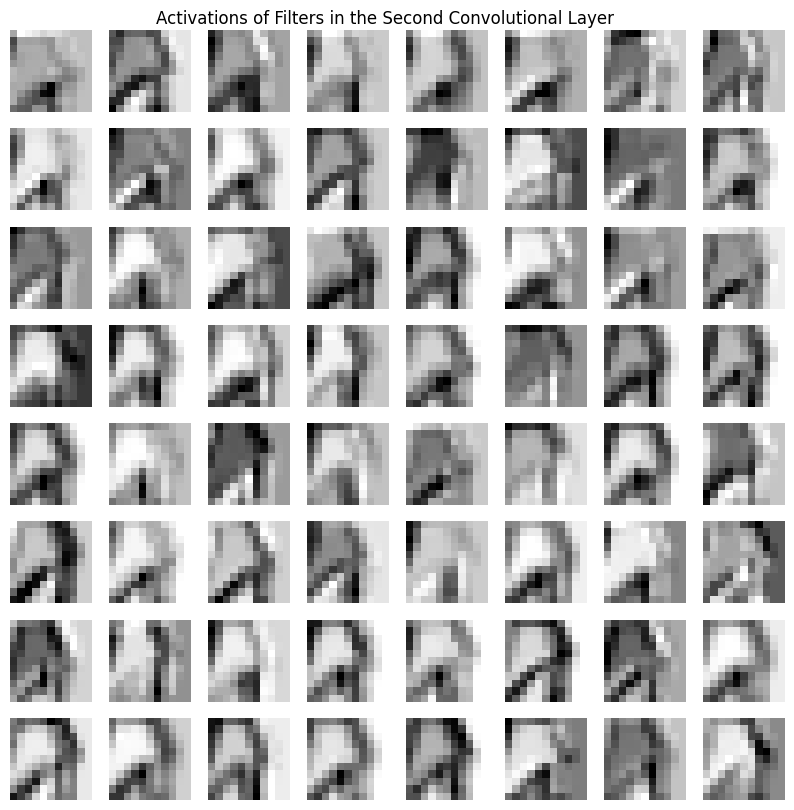

In [ ]:
first_and_second_layer = nn.Sequential(*list(model.children())[:4])

# Lewatkan batch gambar ke lapisan pertama dan kedua
second_layer_activations = first_and_second_layer(x_batch).detach().cpu()

# Visualisasi aktivasi lapisan kedua
fig, axes = plt.subplots(8, 8, figsize=(10, 10))
for i, ax in enumerate(axes.flat):
    if i < second_layer_activations.shape[1]:
        ax.imshow(second_layer_activations[0, i], cmap='gray')
        ax.axis('off')
plt.suptitle('Activations of Filters in the Second Convolutional Layer', y=0.9)
plt.show()

## Aktivasi pada Lapisan Fully Connected

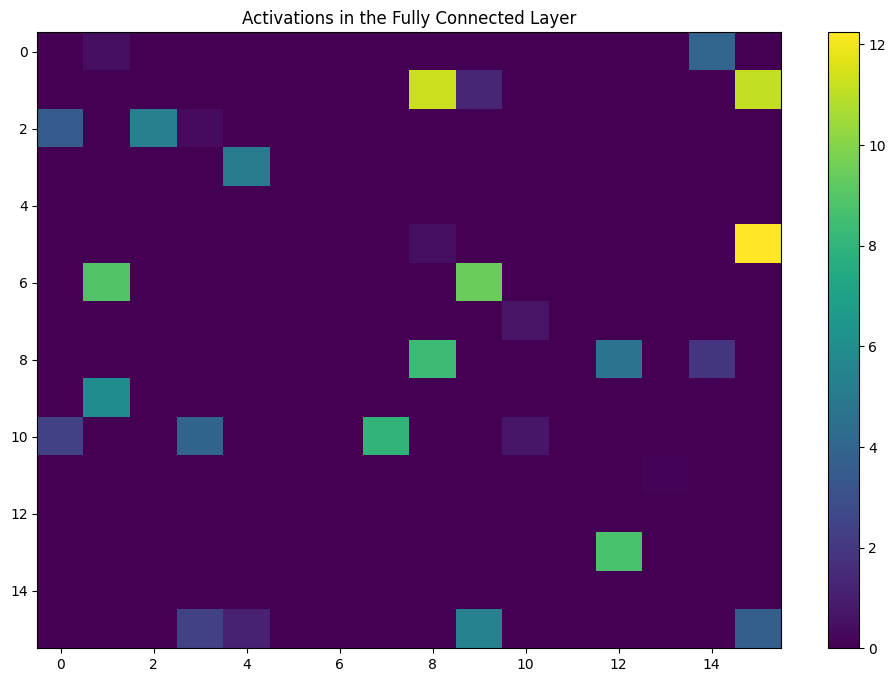

In [ ]:
# Aktivasi pada lapisan fully connected
flatten_layer = nn.Sequential(*list(model.children())[:-1])
flatten_activations = flatten_layer(x_batch).detach().cpu()

# Reshape untuk membuat array menjadi dua dimensi
flatten_activations_reshaped = flatten_activations[0].numpy().reshape(16, 16)  # Misalnya, 256 -> 16x16

# Visualisasi
plt.figure(figsize=(12, 8))
plt.imshow(flatten_activations_reshaped, cmap='viridis', aspect='auto')
plt.colorbar()
plt.title('Activations in the Fully Connected Layer')
plt.show()